In [ ]:
last=0
function printNTimes!(num;times=10)
    for i=1:times
        while((last)%3+1 !=num)
            yield()
        end
        print(num,"\n")
        global last=num
    end
end

print1 = Task(() -> printNTimes!(1))
print2 = Task(() -> printNTimes!(2))
print3 = Task(() -> printNTimes!(3))
schedule(print3);
schedule(print2);
schedule(print1);

## Zadanie 3

In [229]:
using DataFrames
using StatPlots

In [176]:
function setWorkersCount(count)
    for i=2:1000
        rmprocs(i)
    end
    addprocs(count)
    workers()
end

setWorkersCount (generic function with 1 method)

In [177]:
workers()

1-element Array{Int64,1}:
 23

In [178]:
setWorkersCount(1)

1-element Array{Int64,1}:
 24

In [179]:
using Plots
Plots.gr()

Plots.GRBackend()

In [196]:
@everywhere function generate_julia(z; c=2, maxiter=200)
    for i=1:maxiter
        if abs(z) > 2
            return i-1
        end
        z = z^2 + c
    end
    maxiter
end

In [197]:
@everywhere function calc_julia!(julia_set, xrange, yrange; maxiter=200, height=400, width_start=1, width_end=400)
   for x=width_start:width_end
        for y=1:height
            z = xrange[x] + 1im*yrange[y]
            julia_set[x, y] = generate_julia(z, c=-0.70176-0.3842im, maxiter=maxiter)
        end
    end
end

In [182]:
function calc_julia_main_no_parallel(h,w)
   xmin, xmax = -2,2
   ymin, ymax = -1,1
   xrange = linspace(xmin, xmax, w)
   yrange = linspace(ymin, ymax, h)
   julia_set = Array{Int64}(w, h)
   @time calc_julia!(julia_set, xrange, yrange, height=h, width_end=w)

   return Plots.heatmap(xrange, yrange, julia_set)
end

#calc_julia_main(2000,2000)

calc_julia_main_no_parallel (generic function with 1 method)

In [183]:
function calc_julia_main_parallel_for(h,w,threads)
   xmin, xmax = -2,2
   ymin, ymax = -1,1
   yrange = linspace(ymin, ymax, h)
   xrange = linspace(xmin, xmax, w)
   julia_set = SharedArray{Float64}(w, h)
    
   @sync @parallel for i = 0:(threads-1)
        #println(trunc(Int,floor(1+((i/threads)*(w-1))))," : ",trunc(Int,floor(1+(((i+1)/threads)*(w-1)))))
        calc_julia!(julia_set, xrange, yrange, height=h,width_start=trunc(Int,floor(1+((i/threads)*(w-1)))),width_end=trunc(Int,floor(1+(((i+1)/threads)*(w-1)))))
   end
   

   return Plots.heatmap(xrange, yrange, julia_set)
end

#@time calc_julia_main_parallel_for(2000,2000,1)

calc_julia_main_parallel_for (generic function with 2 methods)

In [184]:
data=[]
for i=0:5
    push!(data,["parallel for",1,2^i,@elapsed (calc_julia_main_parallel_for(2000,2000,2^i))])
end
data

6-element Array{Any,1}:
 Any["parallel for", 1, 1, 3.99359] 
 Any["parallel for", 1, 2, 2.57719] 
 Any["parallel for", 1, 4, 2.68253] 
 Any["parallel for", 1, 8, 2.53002] 
 Any["parallel for", 1, 16, 2.68654]
 Any["parallel for", 1, 32, 2.53824]

In [185]:
function calc_julia_main_pmap(h,w,granularity)
   xmin, xmax = -2,2
   ymin, ymax = -1,1
   yrange = linspace(ymin, ymax, h)
   xrange = linspace(xmin, xmax, w)
   julia_set = SharedArray{Float64}(w, h)
   ranges = []
   for i = 0:(granularity-1)
        push!(ranges,[trunc(Int,floor(1+((i/granularity)*(w-1)))),trunc(Int,floor(1+(((i+1)/granularity)*(w-1))))])
        #
   end
   pmap(range -> calc_julia!(julia_set, xrange, yrange, height=h,width_start=range[1],width_end=range[2]), ranges);

   return Plots.heatmap(xrange, yrange, julia_set)
end

calc_julia_main_pmap (generic function with 2 methods)

In [ ]:
setWorkersCount(1)

### Na tym etapie trzeba przeładować funkcje @everywhere (calc i generate)

In [190]:
for i=0:5
    push!(data,["pmap",1,2^i,@elapsed (calc_julia_main_pmap(2000,2000,2^i))])
end

In [258]:
setWorkersCount(10)

10-element Array{Int64,1}:
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65

### Na tym etapie trzeba przeładować funkcje @everywhere (calc i generate)

In [194]:
for i=0:5
    push!(data,["pmap",10,2^i,@elapsed (calc_julia_main_pmap(2000,2000,2^i))])
end

In [195]:
setWorkersCount(20)

20-element Array{Int64,1}:
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55

### Na tym etapie trzeba przeładować funkcje @everywhere (calc i generate)

In [198]:
for i=0:5
    push!(data,["pamp",20,2^i,@elapsed (calc_julia_main_pmap(2000,2000,2^i))])
end

In [199]:
data

24-element Array{Any,1}:
 Any["parallel for", 1, 1, 3.99359] 
 Any["parallel for", 1, 2, 2.57719] 
 Any["parallel for", 1, 4, 2.68253] 
 Any["parallel for", 1, 8, 2.53002] 
 Any["parallel for", 1, 16, 2.68654]
 Any["parallel for", 1, 32, 2.53824]
 Any["pmap", 1, 1, 3.27916]         
 Any["pmap", 1, 2, 2.60541]         
 Any["pmap", 1, 4, 2.7108]          
 Any["pmap", 1, 8, 2.76158]         
 Any["pmap", 1, 16, 2.82997]        
 Any["pmap", 1, 32, 3.54704]        
 Any["pmap", 10, 1, 5.22743]        
 Any["pmap", 10, 2, 2.92037]        
 Any["pmap", 10, 4, 3.23985]        
 Any["pmap", 10, 8, 2.98439]        
 Any["pmap", 10, 16, 1.55053]       
 Any["pmap", 10, 32, 1.41714]       
 Any["pamp", 20, 1, 7.63606]        
 Any["pamp", 20, 2, 2.91852]        
 Any["pamp", 20, 4, 3.5681]         
 Any["pamp", 20, 8, 6.3103]         
 Any["pamp", 20, 16, 4.76315]       
 Any["pamp", 20, 32, 1.90812]       

In [238]:
df = DataFrame(id=1:length(data),sol_type=map(x->x[1],data),worker_count=map(x->x[2],data),granularity=map(x->x[3],data),time=map(x->x[4],data))

,id,sol_type,worker_count,granularity,time
1,1,parallel for,1,1,3.993587925
2,2,parallel for,1,2,2.577185264
3,3,parallel for,1,4,2.682527784
4,4,parallel for,1,8,2.530019012
5,5,parallel for,1,16,2.686540719
6,6,parallel for,1,32,2.538241526
7,7,pmap,1,1,3.279160285
8,8,pmap,1,2,2.605405126
9,9,pmap,1,4,2.710795268
10,10,pmap,1,8,2.761581987


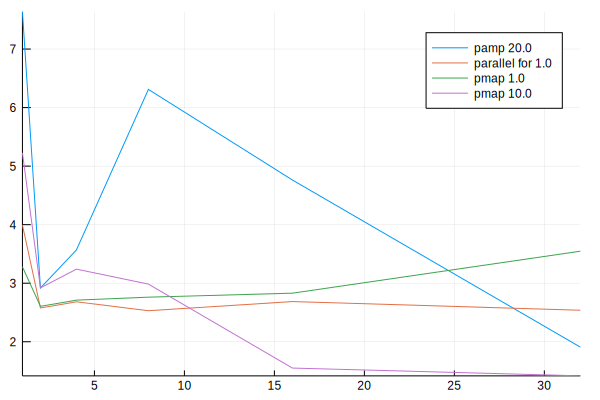

In [255]:
@df df plot(:granularity,:time,group=(:sol_type,:worker_count))